# Import modules

In [96]:
#from netCDF4 import Dataset as Dataset
import xarray as xr
import numpy as np
#import matplotlib
#import glob
#from datetime import datetime
#from wrf import getvar, ALL_TIMES
#import netCDF4 as nc
#import glob
#from datetime import datetime
#import shapefile
#from matplotlib.path import Path
#from matplotlib.patches import PathPatch
#from shapely.geometry import Polygon, Point
#import numpy.ma as ma
#import scipy
#import scipy.stats as stats
from matplotlib import pyplot as plt
#import pandas as pd
#import pytz
from sklearn.cluster import KMeans
import tslearn
from tslearn.clustering import TimeSeriesKMeans as TimeSeriesKMeans

# Load in data

In [39]:
daily_precipitation=xr.open_dataset('/data/PeruGROWS/analysis_data/daily_precip.nc')
lats=xr.open_dataset('/data/PeruGROWS/analysis_data/inner_dom_lats.nc')
lons=xr.open_dataset('/data/PeruGROWS/analysis_data/inner_dom_lats.nc')

#test plot first timestep: plt.contourf(lats.XLAT.values,lons.XLONG.values,daily_precipitation.RAINNC.values[0])

# Sort out data
first, flatten the precipitation, lats and lons data

In [40]:
precip_flat=daily_precipitation.stack(z=('south_north','west_east')).RAINNC.values
# note to self: this is the same as precip_flat2=daily_precipitation.RAINNC.values.reshape(len(daily_precipitation.RAINNC),93*87)
precip_flat2=daily_precipitation.RAINNC.values.flatten()
lats_flat=lats.stack(z=('south_north','west_east'))
lons_flat=lons.stack(z=('south_north','west_east'))
#check plot first timestep: 

# Start with the simplest-looking clustering algorithm to get an idea

### Investigations with kmeans

### The standard klearns in scikit learn optimises based on location. This is not what we need, but here it is. 

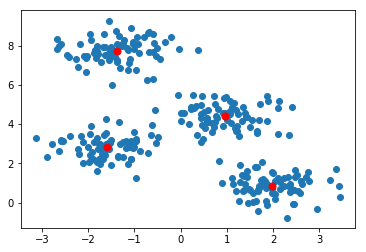

In [60]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
np.shape(X)
plt.scatter(X[:,0], X[:,1])
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)
kmeans.fit(X)
kmeans.cluster_centers_
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],marker='.',s=200,color='r')

### This website has it's own adaptable script for kmeans clustering of timeseries: https://blog.newrelic.com/product-news/optimizing-k-means-clustering/

### Just some sample data

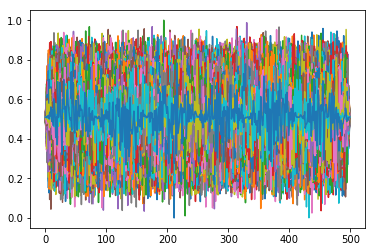

In [91]:
from scipy.cluster.hierarchy import dendrogram, linkage
#create 10000 timeseries
n = 10000
ts_len = 500

phases = np.array(np.random.randint(0, 50, [n, 2]))
pure = np.sin([np.linspace(-np.pi * x[0], -np.pi * x[1], ts_len) for x in phases])
noise = np.array([np.random.normal(0, 1, ts_len) for x in range(n)])

signals = pure * noise
           
# Normalize everything between 0 and 1
signals += np.abs(np.min(signals))
signals /= np.max(signals)

plt.plot(signals[0])
plt.plot(signals.transpose())
plt.show()
#np.shape(signals)

early finish!


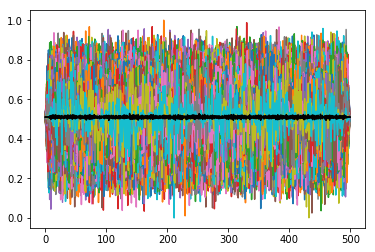

In [155]:
#cluster based on euclidean distance 
def euclid_dist(t1, t2):
    return np.sqrt(((t1-t2)**2).sum(axis = 1))

#calculate how far (using euclidean distance) each time series is from each centroid
def calc_centroids(data, centroids):
    dist = np.zeros([data.shape[0], centroids.shape[0]])

    for idx, centroid in enumerate(centroids): 
        dist[:, idx] = euclid_dist(centroid, data)

    return np.array(dist)

#Find the closest centroid to each time series (hence create an initial cluster by splitting the time series based on which centroid they're closest to)
def closest_centroids(data, centroids): 
    dist = calc_centroids(data, centroids) 
    return np.argmin(dist, axis = 1)

#Find the mean of all the timeseries in each cluster to give the new centroid
def move_centroids(data, closest, centroids):
    k = centroids.shape[0]
    new_centroids = np.array([data[closest == c].mean(axis = 0) for c in np.unique(closest)])

    if k - new_centroids.shape[0] > 0:
       print("adding {} centroid(s)".format(k - new_centroids.shape[0]))
       additional_centroids = data[np.random.randint(0, data.shape[0], k - new_centroids.shape[0])] 
       new_centroids = np.append(new_centroids, additional_centroids, axis = 0)

    return new_centroids

def k_means(data, num_clust, num_iter):
    centroids = signals[np.random.randint(0, signals.shape[0], num_clust)]
    last_centroids = centroids

    for n in range(num_iter):
        closest = closest_centroids(data, centroids)
        centroids = move_centroids(data, closest, centroids)
        if not np.any(last_centroids != centroids):
           print("early finish!")
           break
        last_centroids = centroids 
    
    return centroids

centroids = k_means(signals, 4, 1000) #4 clusters, 100 iterations. Start point is: signals[np.random.randint(0, signals.shape[0], num_clust)], i.e. signals[4 random numbers between 0 and 10000] so just 4 of the timeseries.
plt.plot(signals.transpose())
plt.plot(centroids.transpose(),'k') #n.b. centroids are means so that's why they're so close to 0. This could be similar for precipitation. It might not matter as centroids are just to determine middle of clusters, but might matter because if the centroids tend to 0 the clustering can't work sensibly?
plt.show()


### Also use python inbuilt tslearn and see if we get the same result

In [154]:
km = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=1000,random_state=4).fit(signals)

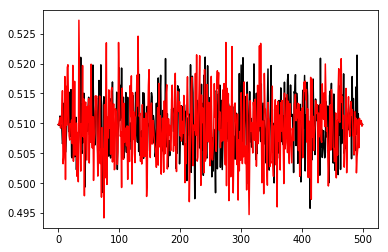

In [163]:
plt.plot(centroids[1],'k')
plt.plot(km.cluster_centers_[0,:,0],'r')
#Nope! not the same....(checked all centroids)...There might be minor differences, and perhaps I wasn't really expecting 
#the clustering to work on a random dataset anyway.


### Create a dataset where we know what the answer should be for testing (n.b. I expect a euclidian algorithm might not be best, just getting a feel for it)

In [236]:
testarray=np.concatenate((np.tile(np.repeat(3,500),[2,1]),np.tile(np.repeat(4,500),[2000,1]),np.tile(np.repeat(9,500),[4000,1]),np.tile(np.repeat(6,500),[300,1])))

adding 2 centroid(s)
adding 1 centroid(s)
early finish!


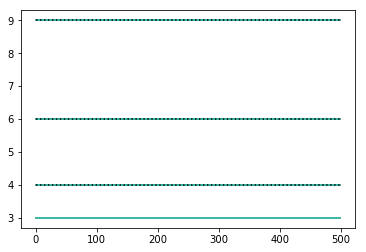

In [250]:
np.shape(testarray)
testcentroids = k_means(testarray, 3, 1000) 
plt.plot(testarray.transpose())
plt.plot(testcentroids.transpose(),'k:') #n.b. centroids are means so that's why they're so close to 0. This could be similar for precipitation. It might not matter as centroids are just to determine middle of clusters, but might matter because if the centroids tend to 0 the clustering can't work sensibly?
plt.show()

#interestingly, if you put very very few time series=3, this only picks out a centroid at 3 if you set to 5 clusters. 
#Possibly due to computer rounding? Get two centroids at 9. However if you change it to 20 time series at 3 get the 4 clusters you'd expect.

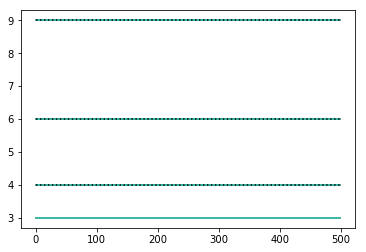

In [251]:
test_km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=1000,random_state=0).fit(testarray)
plt.plot(testarray.transpose())
plt.plot(test_km.cluster_centers_[:,:,0].transpose(),'k:') 
plt.show()
#OK these both behave as I expected. the inbuilt python function is faster. 

# Let's try some precipitation data (might need more iterations?)

In [265]:
precip_km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=1000,random_state=0).fit(precip_flat.transpose())

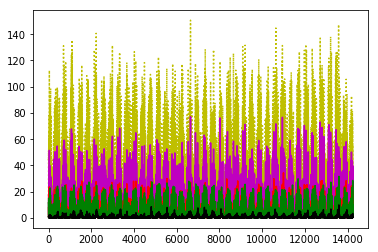

In [268]:
plt.plot(precip_km.cluster_centers_[3,:,0].transpose(),'y:')
plt.plot(precip_km.cluster_centers_[4,:,0].transpose(),'m')
plt.plot(precip_km.cluster_centers_[1,:,0].transpose(),'r')
plt.plot(precip_km.cluster_centers_[2,:,0].transpose(),'g')
plt.plot(precip_km.cluster_centers_[0,:,0].transpose(),'k')


## Interesting! I tried 3 clusters and got 3 distinct precipitation amount groups, 4 clusters had 2 very similar centroids. Ah, but 5 comes up with 4 distinct clusters so it's clearly not that simple! Of course will need to check algorithms and also plot on a map to see if this makes sense